# Programming GIS – Spatial & Geometry Operations on Vector data
**Course:** Programación SIG. Universidad Nacional de Colombia. Facultad de Ciencias Agrarias.  
**Author:** Liliana Castillo Villamor  
**Date:** 2025-05-19  


## Objectives  
* Introduce core **vector‑based spatial operations** available in Python.  
* Apply these operations to Colombian municipal, agro‑environmental and climate datasets.  
* Develop students’ ability to adapt and extend example code.  
* Provide hands‑on practice through **“Now it’s your turn”** exercises.  


## Prerequisites  
This notebook willl use the following datasets

* A conda or mamba environment with `python >= 3.10`, `geopandas`, `shapely`, `rtree` **or** `pygeos`, `pandas`, `contextily`, `matplotlib`.  
* Local copies of the supporting datasets:  

| File | Description | CRS / key fields |
|------|-------------|------------------|
| `Catalogo_Estaciones_IDEAM.csv` | IDEAM meteorological‑station catalogue (lon, lat, alt) | WGS 84 |
| `Evaluaciones_Agropecuarias_Municipales_EVA.csv` | Municipal agricultural production statistics | `COD_MPIO`, crop, area, production |
| `precipitacion.csv` | Daily precipitation per station | Station ID, date, value |
| `municipios_colombia.shp` | Colombian municipalities | EPSG 3116 (MAGNA‑Sirgas / Colombia Bogotá) |

Activate the environment and launch **Jupyter Lab** before running the cells below.


## 1  Introduction  
Spatial operations allow us to ask *where* questions about our data: Which municipalities intersect a given buffer?  
Which weather station is nearest to each crop‑growing area?  
Geometry operations, by contrast, modify or derive new geometries – simplifying boundaries, buffering points, or rotating shapes.  

We will follow and extend chapters 3 and 4 of **_Geocomputation with Python_** (pygeocompx), applying every concept to real Colombian datasets.


### Data used in this notebook  
We combine four datasets:

1. **Municipal boundaries** – official shapefile from DANE (see *MGN2018 Instructivo*).  
2. **EVA** agricultural statistics – municipal‑level production for major crops.  
3. **IDEAM stations** – catalogue with coordinates and basic metadata.  
4. **Daily precipitation** – station‑day totals.

These provide an agricultural–environmental case study for spatial analysis.


## 2. Import Libraries

In [171]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx

plt.rcParams['figure.figsize'] = (10, 8)


## 3.Load & harmonise the data

We import the three source files, tidy a few columns and
ensure **every spatial layer** is projected to *MAGNA-SIRGAS Origen Nacional*
(**EPSG 9377**).  
The EVA table has no coordinates, but we rename its municipality code
to `cod_mun` for consistency.


In [174]:
# --- File paths  ---
root_folder=r"C:/Users/Liliana/OneDrive - Universidad Nacional de Colombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres"
root_folder=r"/Users/macbook/Library/CloudStorage/OneDrive-UniversidadNacionaldeColombia/1_Periodos_Asignaturas/Cursos_2025_1/Programacion SIG/Talleres"

SHAPE_MUN = root_folder+'/municipios_colombia.shp'
EVA_CSV   = root_folder+'/Evaluaciones_Agropecuarias_Municipales_EVA.csv'
EST_CSV   = root_folder+'/Catalogo_Estaciones_IDEAM.csv'



In [176]:
# Municipalities → GeoDataFrame 
gdf_mun = gpd.read_file(SHAPE_MUN).to_crs(epsg=9377)

# EVA table, rename code column
eva = (pd.read_csv(EVA_CSV)
         .rename(columns={"CÓD. MUN.": "cod_mun"}))
eva["CULTIVO"] = eva["CULTIVO"].astype(str)      # ensure string

# IDEAM catalogue → GeoDataFrame (clean "(lat, lon)")
df_est = pd.read_csv(EST_CSV)
coords = (df_est["Ubicación"]
            .str.strip("()")
            .str.split(",", expand=True)
            .astype(float))
df_est["lat"], df_est["lon"] = coords[0], coords[1]

gdf_est = gpd.GeoDataFrame(
    df_est,
    geometry=gpd.points_from_xy(df_est["lon"], df_est["lat"]),
    crs="EPSG:4326"
).to_crs(epsg=9377)

print(f"{len(gdf_mun):,} municipalities • {len(gdf_est):,} stations • "
      f"{len(eva):,} EVA rows")


#Homogenise municipalities codes
gdf_mun["MPIO_CCDGO"] = gdf_mun["MPIO_CCDGO"].astype(str).str.zfill(5)
eva["cod_mun"]        = eva["cod_mun"].astype(str).str.zfill(5)

1,122 municipalities • 8,973 stations • 206,068 EVA rows


Head of re-projected station GeoDataFrame:


,Codigo,Nombre,Categoria,Estado,Departamento,Municipio,Ubicación,Altitud,Fecha_instalacion,Fecha_suspension,Corriente,lat,lon,geometry
0,52057100,RUMICHACA - AUT [52057100],Limnigráfica,Activa,Nariño,Ipiales,"(0.81378611, -77.66197778)",2582,2016-11-15,NaN,Guaitara,0.813786,-77.661978,POINT (4.48e+06 1.65e+06)
1,52055170,LA JOSEFINA - AUT [52055170],Climática Principal,Activa,Nariño,Contadero,"(0.93030556, -77.49119444)",2450,2005-12-10,NaN,Guaitara,0.930306,-77.491194,POINT (4.5e+06 1.66e+06)
2,52055220,EL PARAISO - AUT [52055220],Climática Principal,Activa,Nariño,Túquerres,"(1.07061111, -77.63688889)",3120,2004-03-01,NaN,Guaitara,1.070611,-77.636889,POINT (4.48e+06 1.68e+06)
3,44015070,EL PEPINO - AUT [44015070],Climática Principal,Activa,Putumayo,Mocoa,"(1.08288889, -76.66711111)",760,2005-11-11,NaN,Guaitara,1.082889,-76.667111,POINT (4.59e+06 1.68e+06)
4,48015040,PUERTO NARINO - AUT [48015040],Climática Principal,Activa,Amazonas,Puerto Nariño,"(-3.78030556, -70.36263889)",158,2005-07-19,NaN,Amazonas,-3.780306,-70.362639,POINT (5.29e+06 1.14e+06)


gdf_mun columns Index(['DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION',
       'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO',
       'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO',
       'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M',
       'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N',
       'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N',
       'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA',
       'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI',
       'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC',
       'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2',
       'STP19_EE_3', 'STP19_EE_4', 'STP19_EE_5', 'STP19_EE_6', 'STP19_EE_9',
       'STP19_ACU1', 'STP19_ACU2', 'STP19_ALC1', 'STP19_ALC2', 'STP19_GAS1',
       'STP19_GAS2', 'STP19_GAS9', 'STP19_REC1', 'STP19_REC2', 'STP19_

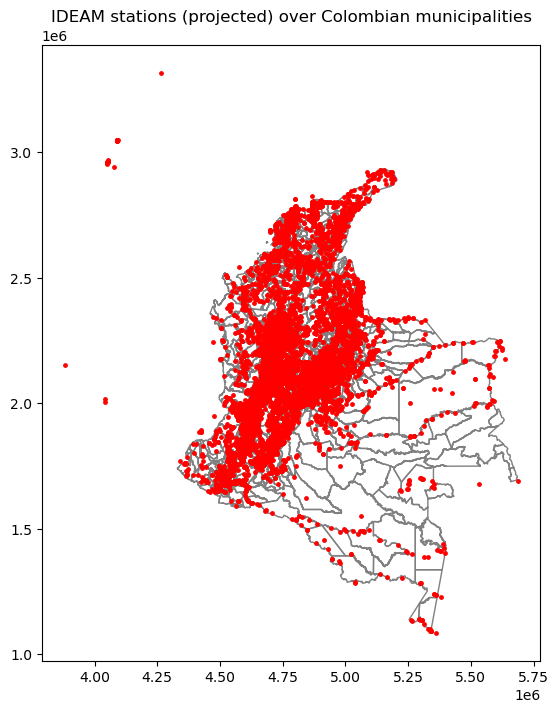

In [177]:

# ── Quick checks ───────────────────────────────────────────────────────────
print("Head of re-projected station GeoDataFrame:")
display(gdf_est.head())
print("gdf_mun columns",gdf_mun.columns)
ax = gdf_mun.plot(color="none", edgecolor="grey", figsize=(8, 8))
gdf_est.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Colombian municipalities")
plt.show()

In [178]:
print(eva["CULTIVO"].unique())
print(eva.columns)

['ACELGA' 'ACHICORIA' 'MALANGA' 'ACHIRA' 'ACHIOTE' 'AGRAZ' 'AGUACATE'
 'AJI' 'AGUAJE' 'AHUYAMA' 'AJO' 'AJONJOLI' 'ALBAHACA' 'ALFALFA'
 'ALCACHOFA' 'ALGARROBO' 'ALGODON' 'AMARANTO' 'ANIS' 'ANON' 'ANTURIO'
 'APIO' 'ARANDANO' 'ARAZA' 'ARRACACHA' 'ARROZ' 'ARVEJA' 'ASAI'
 'ASPARRAGUS' 'ASTROMELIA' 'AVENA' 'BACURI' 'BADEA' 'BANANITO' 'BANANO'
 'BATATA' 'BERENJENA' 'BREVO' 'BORE' 'BOROJO' 'BROCOLI' 'CACAO' 'PLATANO'
 'CADUCIFOLIOS' 'CAFE' 'CAUCHO' 'CAIMO' 'CALABACIN' 'CALABAZA' 'CALENDULA'
 'CANYARANA' 'CAÑA AZUCARERA' 'CAÑA FLECHA' 'CAÑA MIEL' 'CAÑA PANELERA'
 'CARDAMOMO' 'CEBADA' 'CEBOLLA DE BULBO' 'CENTENO' 'CEBOLLA DE RAMA'
 'CEBOLLIN' 'CHACHAFRUTO' 'CHAMBA' 'CHAMPIÑON' 'CHIA' 'CIMARRON'
 'CHIRIMOYA' 'CHOLUPA' 'CIRUELA' 'CHONQUE' 'CHONTADURO' 'CITRICOS'
 'CILANTRO' 'CLAVEL' 'COCCULUS' 'COCO' 'COCONA' 'COL' 'CURUBA' 'COLIFLOR'
 'COPOAZU' 'CORDELINE CINTA' 'COROZO' 'CURCUMA' 'DATIL' 'DURAZNO' 'ENELDO'
 'ESPARRAGO' 'ESPARTO' 'ESPINACA' 'ESTROPAJO' 'EUCALIPTO BABY BLUE'
 'FEIJOA' 'FIQUE' 'FIT

## 4  Spatial operations on vector data

### 4.2.1  Spatial subsetting  
*Spatial subsetting* returns a new layer that contains only the
features with a defined spatial relationship to another layer.

#### Identifying IDEAM stations within Bogotá D.C.

* We first filter gdf_mun by the municipal name containing “BOGOTÁ”  and make an explicit copy to avoid modifying the original GeoDataFrame. The **upper()** method is applied to each string in the Series, converting all characters to uppercase.
Ejemplo: "Bogotá D.C." → "BOGOTÁ D.C.".
Esto se hace para que la búsqueda con contains("BOGOTÁ") no sea sensible a mayúsculas/minúsculas (case-insensitive).
* Then, for each IDEAM station point, .intersects(...) checks whether it lies inside Bogotá’s polygon. The result is a Boolean Series (True if the station is within the polygon, otherwise False). By writing .iloc[0], you extract the first (and in this case, only) Polygon from that GeoSeries.


In [182]:

bogota_muni = gdf_mun[gdf_mun["MPIO_CNMBR"].str.upper().str.contains("BOGOTÁ")].copy()

bta_stations_bool = gdf_est.intersects(bogota_muni.geometry.iloc[0])
bta_stations_bool # Display the boolean dataset

0       False
1       False
2       False
3       False
4       False
        ...  
8968    False
8969    False
8970    False
8971    False
8972    False
Length: 8973, dtype: bool

Finally, we can subset the statios using the obtained Series, resulting in the subset canterbury_height with only those stations that intersect with Bogotá.



In [184]:
bogota_stations = gdf_est[bta_stations_bool]
print(bogota_stations)

          Codigo                                          Nombre  \
92      21206920                   VILLA TERESA - AUT [21206920]   
124     21206960                  IDEAM BOGOTA  - AUT [21206960]   
125     21205012          UNIVERSIDAD NACIONAL  - AUT [21205012]   
303   2120500127           RADIO SONDA BOGOTA - AUT [2120500127]   
318     21206570                     AEROPUERTO CATAM [21206570]   
...          ...                                             ...   
8952  2120000141    COLEGIO VEINTIUN ANGELES - AUT  [2120000099]   
8953  2120000144  COLEGIO ALEMANIA SOLIDARIA - AUT  [2120000100]   
8955  2120000149      COLEGIO RODOLFO LLINAS - AUT  [2120000109]   
8956  2120000150                 GRAN BRETAÑA - AUT [2120000106]   
8957  2120000151                         LA FISCALA [2120000107]   

                Categoria      Estado Departamento    Municipio  \
92    Climática Principal      Activa       Bogotá  Bogota, D.C   
124   Climática Principal      Activa       Bogot

#### Display the stations over the boundaries of Bogota

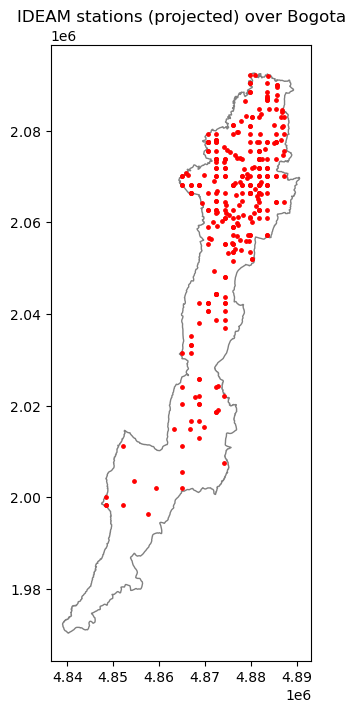

In [186]:
ax = bogota_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
bogota_stations.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Bogota")
plt.show()

#### Display the results in the within the country


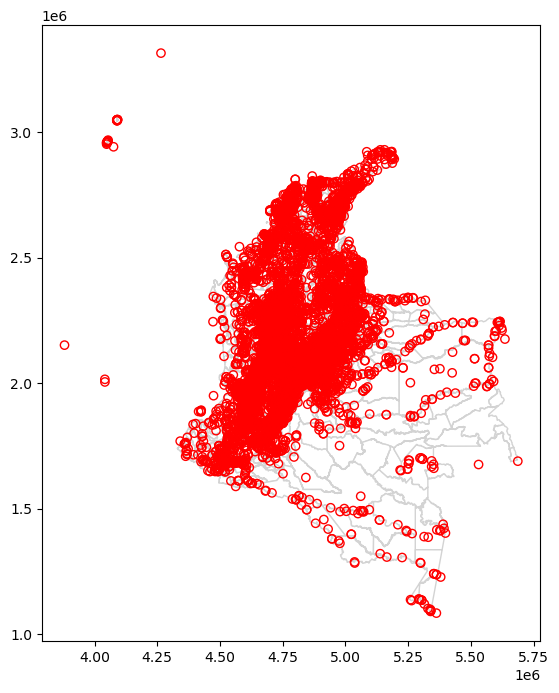

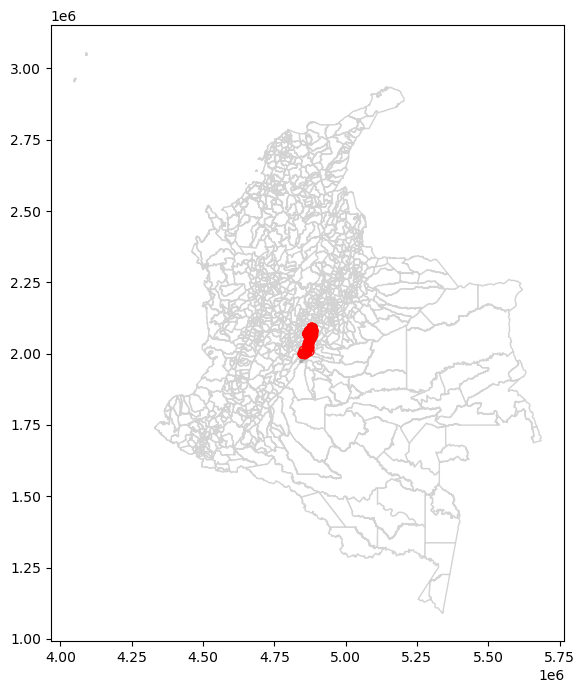

In [188]:
# Original
base = gdf_mun.plot(color='white', edgecolor='lightgrey')
gdf_est.plot(ax=base, color='None', edgecolor='red');
# Subset (intersects)
base = gdf_mun.plot(color='white', edgecolor='lightgrey')
bogota_muni.plot(ax=base, color='lightgrey', edgecolor='darkgrey')
bogota_stations.plot(ax=base, color='None', edgecolor='red');


### Other topological relations
Other topological relations can be used for spatial subsetting. These include touches, crosses, or within. As an example of another method, we can use .disjoint to obtain all points that do not intersect with Bogotá.

In [203]:
cumaribo_muni = gdf_mun[gdf_mun["MPIO_CNMBR"].str.upper().str.contains("CUMARIBO")].copy()

cumaribo_muni_bool_disj = gdf_est.disjoint(cumaribo_muni.geometry.iloc[0])
cumaribo_muni_bool_disj # Display the boolean dataset
non_cumaribo_stations = gdf_est[cumaribo_muni_bool_disj ]

#### Plotting the results (In a fancier way
Using fig, ax = plt.subplots(...) gives you full control over the figure and axes—especially useful when you need to:

* Specify figure size or resolution (e.g., fig, ax = plt.subplots(figsize=(8, 6))).

* Create multiple maps (subplots) in a single figure (for example, plt.subplots(nrows=1, ncols=2)).

*  Customize titles, legends, annotations, or other elements directly via ax.set_title(), ax.legend(), ax.text(), etc.m

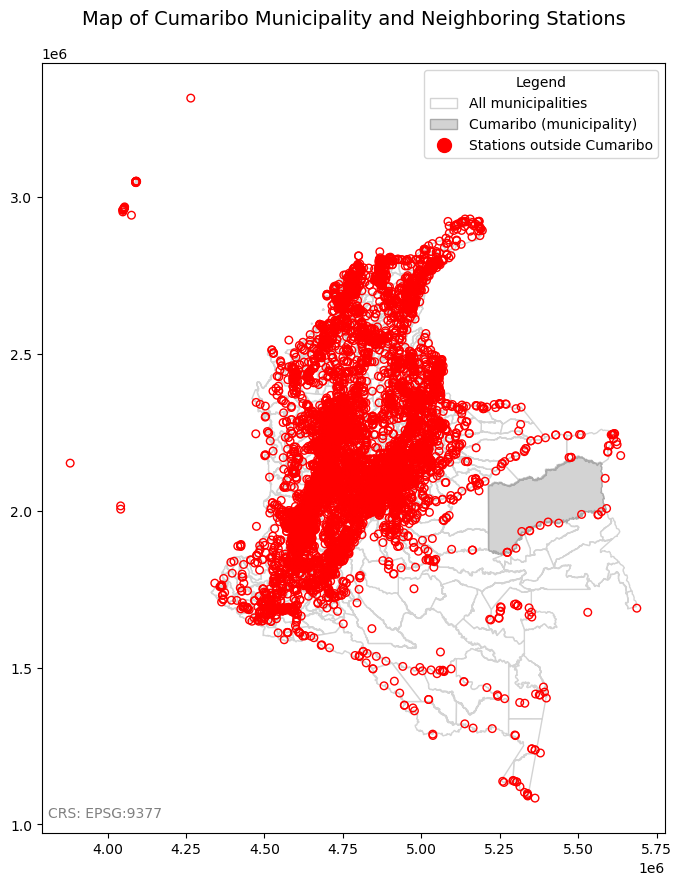

In [206]:
# matplotlib.patches makes available Matplotlib’s “patch” objects, which are simple filled shapes (e.g., rectangles, or polygons) to create a small coloured box or shape.
import matplotlib.patches as mpatches 

# matplotlib.lines provides access to Matplotlib’s “line” objects. E.g. individual markers and line styles. 
# By creating a `Line2D` object with a specific marker and no connecting line (for example, a red circle), you can generate a legend entry that matches how point data are drawn on the map. 
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(10, 10))

# 1. Base layer: all municipalities
gdf_mun.plot(
    ax=ax,
    color='white',
    edgecolor='lightgrey'
)

# 2. Highlight Cumaribo municipality
cumaribo_muni.plot(
    ax=ax,
    color='lightgrey',
    edgecolor='darkgrey'
)

# 3. Plot stations not in Cumaribo
non_cumaribo_stations.plot(
    ax=ax,
    color='None',
    edgecolor='red',
    marker='o',
    markersize=30
)

# 4. Title
ax.set_title(
    "Map of Cumaribo Municipality and Neighboring Stations\n",
    fontsize=14,
    pad=12
)

# 5. Create proxy artists for the legend
#    - Patch for “All municipalities” (white fill, lightgrey edge)
patch_allmun = mpatches.Patch(
    facecolor='white',
    edgecolor='lightgrey',
    label='All municipalities'
)

#    - Patch for “Cumaribo” (lightgrey fill, darkgrey edge)
patch_cumaribo = mpatches.Patch(
    facecolor='lightgrey',
    edgecolor='darkgrey',
    label='Cumaribo (municipality)'
)

#    - Line2D for “Stations outside Cumaribo” (red circle marker)
marker_stations = mlines.Line2D(
    [], [], 
    color='red',   # edgecolor of the marker
    marker='o',
    linestyle='None',
    markersize=10,
    label='Stations outside Cumaribo'
)

# 6. Add the legend using those proxy handles
ax.legend(
    handles=[patch_allmun, patch_cumaribo, marker_stations],
    loc='upper right',
    title='Legend',
    frameon=True
)

# 7. Annotate CRS info in the bottom-left corner
crs_text = f"CRS: {gdf_mun.crs.to_string()}"
ax.text(
    0.01, 0.02, crs_text,
    transform=ax.transAxes,
    fontsize=10,
    color='grey',
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2)
)

plt.show()


#### Now it’s your turn #1 – Spatial subsetting variation

For a variation on the previous spatial subsetting exercise, pick a **department** of your choice and:

- Dissolve all its municipality polygons into a single department-level geometry.  
- Subset the IDEAM station GeoDataFrame to keep only those points that **intersect** your department polygon.  

**Deliverables**  
1. A small table listing the station IDs and names you selected.  
2. A map showing your dissolved department boundary (in grey) with the intersecting stations overlaid (in a contrasting colour).  


# Solucion 

Stations in Antioquia:
          Codigo                                    Nombre
0       21195170                  PAQUILO - AUT [21195170]
1       23125170             SAN CAYETANO - AUT [23125170]
2       21195190                    PASCA - AUT [21195190]
3       21237010                   NARINO - AUT [21237010]
4       21195160                    SUBIA - AUT [21195160]
...          ...                                       ...
1053  3505500121   PIDEMONTE CHINGAZA - AUT   [3505500121]
1054  2120700156                                     CHICU
1055  2120700158                                 EL TABACO
1056  2120700157                                 LA RAMADA
1057  2120000145  ALTOS DE LA ESTANCIA - AUT  [2120000101]

[1058 rows x 2 columns]


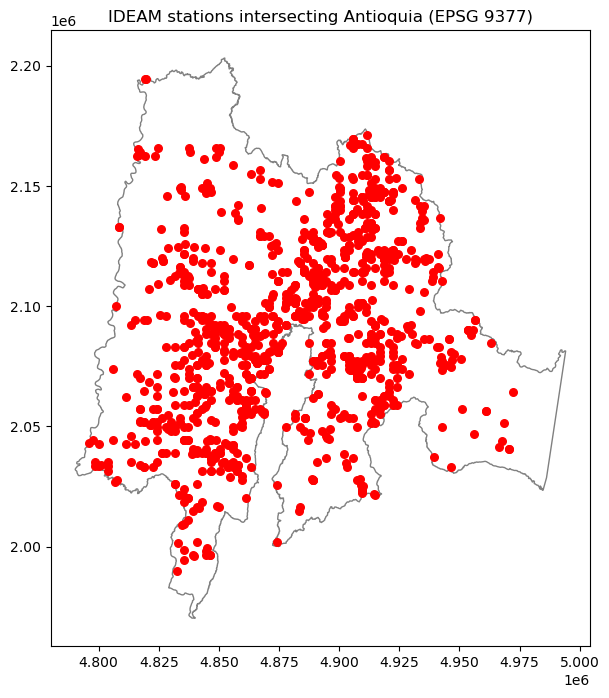

In [196]:
# 1. Diseñar la operación de disolución para Antioquia
antioquia = (
    gdf_mun[gdf_mun["DPTO_CCDGO"] == "25"]  # filtrar municipios de Cundinamarca
    .dissolve()                                    # unirlos en un solo polígono
)

# 2. Calcular la máscara booleana de intersección
mask_ant = gdf_est.intersects(antioquia.geometry.iloc[0])

# 3. Subconjunto de estaciones que caen dentro de Antioquia
stations_ant = gdf_est[mask_ant]

# 4. Mostrar una tabla breve con IDs y nombres
print("Stations in Antioquia:")
print(stations_ant[["Codigo", "Nombre"]].reset_index(drop=True))

# 5. Visualizar el resultado
ax = antioquia.plot(color="none", edgecolor="grey", figsize=(8, 8))
stations_ant.plot(ax=ax, color="red", markersize=30)
plt.title("IDEAM stations intersecting Antioquia (EPSG 9377)")
plt.show()


### 3.2.2  Topological relations

Topological relations describe the spatial relationships between objects. 

*`intersects`*, *`within`*, *`touches`* etc. describe how geometries relate without measuring distance.  
In the cell below, we identify all IDEAM stations located within a 10 km radius of Bogotá’s municipal boundary and then plots them on a map:


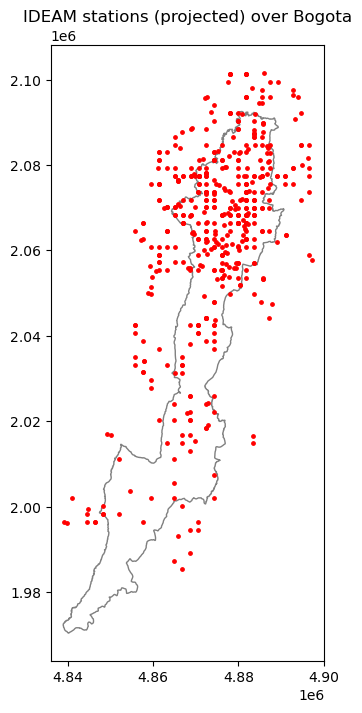

In [207]:
#points.distance(poly.iloc[0]) < 0.2

bta__10km_stations_bool = gdf_est.distance(bogota_muni.geometry.iloc[0])<10000
bta__10km_stations_bool # Display the boolean dataset
bta_10km_stations=gdf_est[bta__10km_stations_bool]

ax = bogota_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
bta_10km_stations.plot(ax=ax, color="red", markersize=6)
plt.title("IDEAM stations (projected) over Bogota")
plt.show()

### Now it’s your turn #4 – Selecting stations just outside Bogotá

Use the Bogotá polygon (`bogota_muni`) to identify all IDEAM stations that lie **outside** the city boundary but within a **20 km** buffer around it. In other words, you need to:

1. Compute the distance from each station point in `gdf_est` to the Bogotá polygon.  
2. Create a boolean mask that is `True` when the station is **farther than 0 m** (i.e., not inside Bogotá) **and closer than 20 000 m** to the polygon.  
3. Use that mask to subset `gdf_est`, obtaining only those stations in the 0–20 km “ring” around the city.  
4. Plot Bogotá’s boundary (grey outline) and overlay the selected stations (e.g., red points) to confirm visually that none of them are inside the polygon but all are within 20 km.


# Solution for Now it’s your turn #4


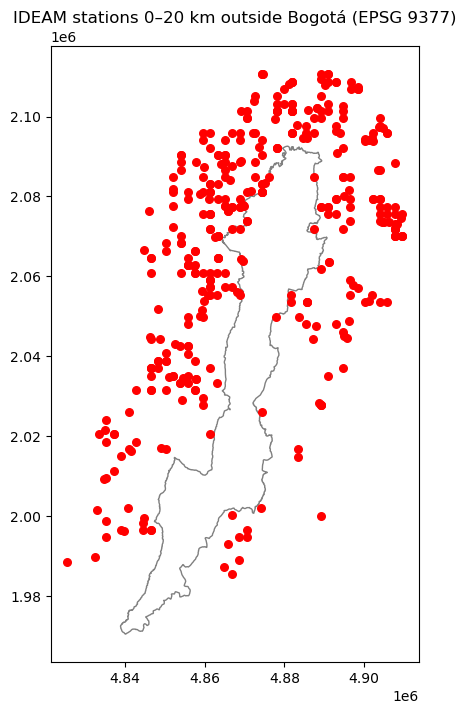

In [216]:
# 1. Extract the single Bogotá polygon
bogota_geom = bogota_muni.geometry.iloc[0]

# 2. Create separate boolean masks
inside_mask     = gdf_est.intersects(bogota_muni.geometry.iloc[0])            # True for stations inside Bogotá
within20km_mask = gdf_est.distance(bogota_muni.geometry.iloc[0])<20000  # True for stations within 20 km

# 3. Combine masks: outside Bogotá AND within 20 km
ring_mask = (~inside_mask) & within20km_mask

# 4. Subset gdf_est to get only stations in the 0–20 km ring
ring_stations = gdf_est[ring_mask]


# 6. Plot Bogotá boundary and the ring stations
ax = bogota_muni.plot(color="none", edgecolor="grey", figsize=(8, 8))
ring_stations.plot(ax=ax, color="red", markersize=30)
plt.title("IDEAM stations 0–20 km outside Bogotá (EPSG 9377)")
plt.show()


### **Now it’s your turn #2**  
Find all stations that **touch** (share a border with) any municipality in the Department of *Antioquia*.  
List their codes and names, then compute the mean altitude.


### 3.2.3  Spatial joining

Spatial joins transfer attributes based on spatial relationships.  
Here we join each municipality to its **nearest** IDEAM station to append the station code.


In [ ]:
# Ensure that the municipalities datframe CRS matches the Stations
gdf_est_proj = gdf_est.to_crs(gdf_mun.crs)

joined = gpd.sjoin_nearest(gdf_mun, gdf_est_proj[['station_id', 'geometry']], how='left', distance_col='dist_km')
joined['dist_km'] = joined['dist_km'] / 1000  # convert m to km

joined[['NOMBRE_MUN', 'station_id', 'dist_km']].head()


### 3.2.4  Non‑overlapping joins

When features do **not** overlap, use nearest joins or buffer‑based joins to bridge the gap.  
The `distance_col` helps assess whether the join is meaningful.


### 3.2.5  Spatial aggregation

In [ ]:
# Department‑level total maize production
maiz_dep = maiz_mun.dissolve(by='DPTO_CNMBR', aggfunc={'PRODUCTION':'sum'})
maiz_dep.sort_values('PRODUCTION', ascending=False).head()


### 3.2.6  Joining incongruent layers

Always re‑project layers to a **common projected CRS** (metres) before measuring area or distance.  
`gdf.to_crs('EPSG:3116')` is suitable for Colombian mainland analyses.


### 3.2.7  Distance relations

In [ ]:
# Example – count municipalities within 20 km of each station
buf20 = gdf_est_proj.copy()
buf20['geometry'] = buf20.buffer(20000)  # 20 km

counts = gpd.sjoin(gdf_mun, buf20, how='inner').groupby('station_id').size()
counts.head()


## 4  Geometry operations on vector data

### 4.2.1  Simplification

In [ ]:
# Simplify a municipality boundary with Douglas–Peucker 500 m tolerance
poly = gdf_mun.iloc[0].geometry
simple = poly.simplify(500)

gpd.GeoSeries({'Original': poly, 'Simplified': simple}).plot(alpha=0.5, edgecolor=['black','red'])
plt.title('Boundary simplification (500 m tolerance)')
plt.show()


### 4.2.2  Centroids

In [ ]:
gdf_mun['centroid'] = gdf_mun.centroid
ax = gdf_mun.plot(color='white', edgecolor='grey')
gdf_mun.set_geometry('centroid').plot(ax=ax, color='darkgreen', markersize=2)
plt.title('Municipality centroids')
plt.show()


### 4.2.3  Buffers

In [ ]:
# Buffer 5 km around municipal capitals (assuming capital coordinates exist)
gdf_mun['buffer5'] = gdf_mun.centroid.buffer(5000)
gdf_mun.set_geometry('buffer5').plot(alpha=0.4)
plt.title('5 km buffers around municipality centroids')
plt.show()


### 4.2.4  Affine transformations

In [ ]:
from shapely import affinity

rot = affinity.rotate(poly, 45, origin='centroid')
gpd.GeoSeries({'Original': poly, 'Rotated 45°': rot}).plot(alpha=0.4, edgecolor=['black','orange'])
plt.show()


### 4.2.5  Pairwise geometry‑generating operations

In [ ]:
# Union of municipalities within Antioquia
antioq = gdf_mun[gdf_mun['DPTO_CNMBR'] == 'ANTIOQUIA']
ant_union = antioq.unary_union

gpd.GeoSeries(ant_union).plot(color='lightblue', edgecolor='black')
plt.title('Geometry union – Antioquia')
plt.show()


### 4.2.6  Subsetting vs. clipping

| **Subsetting** | **Clipping** |
|---|---|
| Keeps **whole** geometries that satisfy a predicate | **Cuts** geometries at boundary of mask |
| Faster, preserves topology | Produces new geometry shapes |


### 4.2.7  Geometry unions

`unary_union` collapses many polygons into one for dissolved analysis or masking.

### 4.2.8  Type transformations

`explode()` converts **MultiPolygon** features into individual **Polygon** rows for per‑feature operations.


## **Now it’s your turn – synthesis exercise**  
Using at least **two geometry operations** *and* one **spatial join**, create an analysis that answers a question of your choice about Colombian agriculture and climate.  

Example ideas:  

* Buffer each IDEAM station by 30 km, intersect with maize production polygons, and compute average yield per buffered zone.  
* Simplify departmental boundaries, then join station precipitation normals and map departments coloured by mean rainfall.  

Present:  
1. A short narrative (Markdown).  
2. The code.  
3. A map and any summary tables.  


## Further reading  
* **Geocomputation with Python** – Chapters 3 & 4 (<https://py.geocompx.org/>)  
* *geopandas* documentation – <https://geopandas.org/>  
* DANE. **MGN2018 – Manual de uso**.  


---  
© 2025 Universidad Nacional de Colombia – Facultad de Ciencias Agrarias 
Liliana Castillo Villamor
This notebook is released under a Creative Commons Attribution 4.0 licence.  
